<a href="https://colab.research.google.com/github/Lone5267/NLP_Learn/blob/master/Do_Spell_Correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

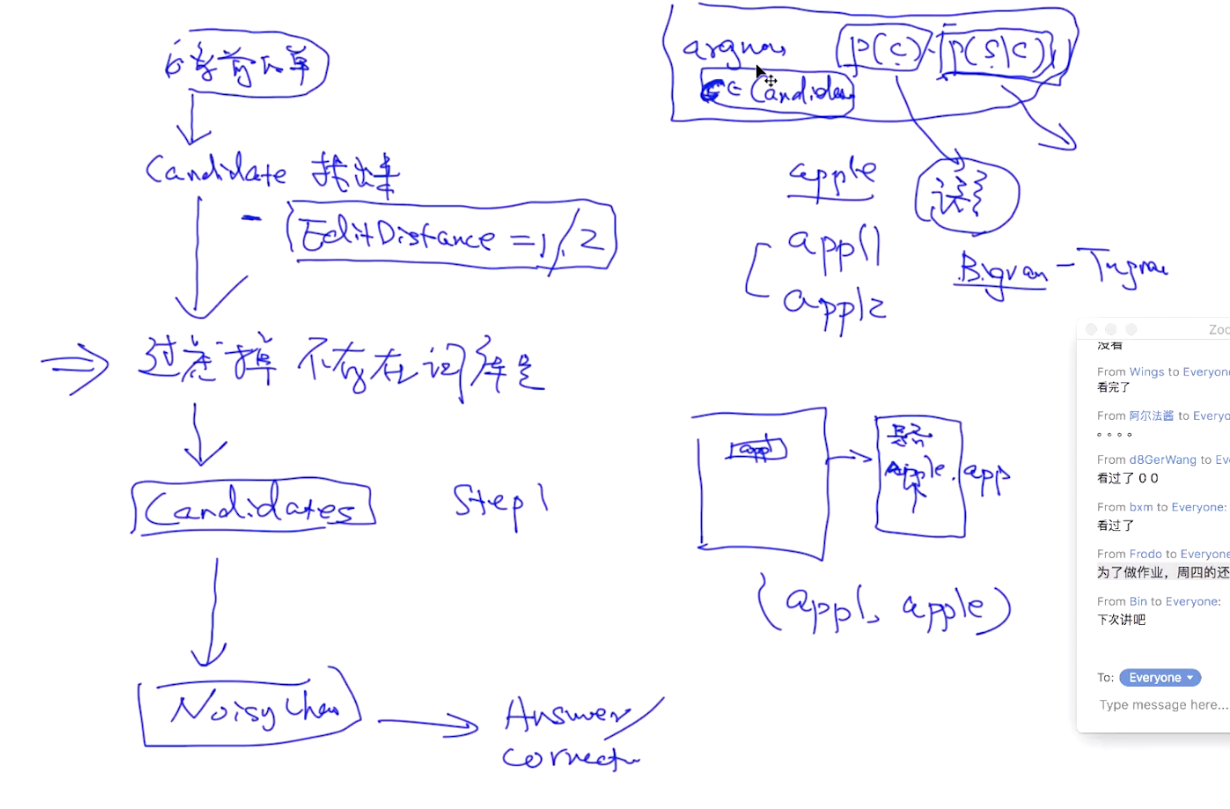



In [0]:
#词典库
vocab = set([line.rstrip() for line in open('/content/drive/My Drive/Colab Notebooks/DO WORK/SpellCorrectionData/vocab.txt')])


In [0]:
#需要生成所有候选集合
def generate_candidates(word):
    """
    word: 给定的输入（错误的输入）
    返回所有（valid）候选集合
    """
    #生成编辑距离为1的单词
    #1.insert 2.delete 3.replace

    #假设使用26个字符
    letters = 'abcdefghijklmnopqrstuvwxyz'

    splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]

    #insert操作
    inserts = [L + c + R for L, R in splits for c in letters]

    #delete操作
    deletes = [L + R[1:] for L, R in splits if R]

    #replace操作
    replaces = [L + c + R[1:] for L, R in splits for c in letters]
    
    candidates = set(inserts + deletes + replaces)

    #过滤掉不在于词典库里的单词
    return [candi for candi in candidates if candi in vocab and candi != word]


#generate_candidates("apple")

In [0]:
import nltk
from nltk.corpus import reuters

#nltk.download('reuters')
#nltk.download('punkt')

#读取语料库
categories = reuters.categories()
corpus = reuters.sents(categories=categories)


In [0]:
#print(corpus)

In [0]:
#构建语言模型：uigram, bigram, tri-gram, use:bigram

term_count = {}
bigram_count = {}

for doc in corpus:
    doc = ['<s>'] + doc
    for i in range(0, len(doc) - 1):
        #bigram: [i i+1]
        term = doc[i]
        bigram = doc[i:i+2]

        if term in term_count:
            term_count[term] += 1
        else:
            term_count[term] = 1

        bigram = ' '.join(bigram)
        if bigram in bigram_count:
            bigram_count[bigram] += 1
        else:
            bigram_count[bigram] = 1

#print(term_count)

In [0]:
#用户犯错的概率统计 - channel probaility

channel_prob = {}
for line in open('/content/drive/My Drive/Colab Notebooks/DO WORK/SpellCorrectionData/spell-errors.txt'):
    items = line.split(':')
    correct = items[0].strip()
    mistakes = [item.strip() for item in items[1].strip().split(',')]
    channel_prob[correct] = {}
    for mis in mistakes:
        channel_prob[correct][mis] = 1.0/len(mistakes)
        

In [0]:
import numpy as np

V = len(term_count.keys())

file = open('/content/drive/My Drive/Colab Notebooks/DO WORK/SpellCorrectionData/testdata.txt', 'r')

for line in file:
    items = line.rstrip().split('\t')
    lines = items[2].split()
    for word in lines:
        if word not in vocab:
            #需要替换word成正确的单词
            #Step1: 生成所有的候选集合
            candidates = generate_candidates(word)
            probs = []
            #对于每个candidate，计算它的score
            #score = p(correct)*p(mistake|correct)
            #      = log(p(correct)) + log(p(mistake|corrcet))
            #返回condidate，会使得score最大
            if (len(candidates) < 1):
                continue

            for candi in candidates:
                prob = 0
                #a. 计算channel probaility
                if candi in channel_prob and word in channel_prob[candi]:
                    prob += np.log(channel_prob[candi][word])
                else:
                    prob += np.log(1.0 / V) #need smoothing
                
                #b. 计算语言模型的概率
                wordList = items[2].split()
                idx = wordList.index(word)
                
                # 计算前项加当前的candi
                # TODO 此处教程有误，还要考虑大小写
                biword = wordList[idx - 1] + " " + candi
                if biword in bigram_count:
                    prob += np.log((bigram_count[biword] + 1.0) / (
                            term_count[wordList[idx - 1]] + V))
                else:
                    prob += np.log(1.0 / V)
                # TODO: 也要考虑当前 [word, post_word]
                #   prob += np.log(bigram概率)
                if (idx + 1 < len(wordList)):
                    biword = candi + " " + wordList[idx + 1]
                    if biword in bigram_count:
                        prob += np.log((bigram_count[biword] + 1.0) / (
                                term_count[wordList[idx + 1]] + V))
                    else:
                        prob += np.log(1.0 / V)

                probs.append(prob)
            #print(probs)
            max_idx = probs.index(max(probs))
            #print(max_idx)
            #print (word, candidates[max_idx])